In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

LABEL2METHOD = {
    "NaiveMix": "active",
    "Separate": "isolated",
    "LaMix-LLF": "interval",
    "LaMix-MLF": "interval-MLF",
}
LABEL2LINESTYLE = {
    "NaiveMix": "-",
    "Separate": "dotted",
    "LaMix-LLF": (0, (1, 10)),
    "LaMix-MLF": '-',
}
METRIC2NAME = {
    'loss': 'Loss',
    'end2end_latency': 'Runtime [s]',
    'idles': 'Idle [s]',
    'user_response': 'Response [ms]',
}
color1 = sns.color_palette("deep")[0]
color2 = sns.color_palette("deep")[1]

### Section 2.2 Mixtraining is useful

In [13]:
def plot_box(
    label1='Separate', 
    label2='NaiveMix', 
    priority='FIFO', 
    load_balancing='random', 
    num_nodes=2, 
    models=['DialoGPT-small', 'DialoGPT-medium', 'DialoGPT-large'], 
    length_distribution='random',
    lambda_ = 10,
    retrain_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    legend = True,
):
    data = []
    res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
    for retrain_rate in retrain_rates:
        for model in models:
            # Separate
            res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}-split{retrain_rate}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
            res["retrain_rate"] = retrain_rate
            res["model"] = model
            res['method'] = label1
            data.append(res)
            # Mixtraining
            res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label2]}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
            res["retrain_rate"] = retrain_rate
            res["model"] = model
            res['method'] = label2
            data.append(res)
        
    data = pd.DataFrame(data)
    os.makedirs("figure", exist_ok=True)

    # Four metrics in subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
    methods = data['method'].unique().tolist()
    metrics = ['loss', 'end2end_latency', 'idles', 'user_response']
    colors = ['peachpuff', 'lightsteelblue']  # Using only two methods
    # colors = [color1, color2]
    hatches = ['/', 'x']  # Using only two methods
    legend_patches = [mpatches.Patch(facecolor=colors[i], 
                                     hatch=hatches[i], 
                                     edgecolor='black', 
                                     label=method) for i, method in enumerate(methods)]

    for metric, ax in zip(metrics, axes):
        for i, (retrain_rate, group_data) in enumerate(data.groupby('retrain_rate')):
            positions = [i + offset*0.3 for offset in range(len(methods))]
            for method in methods:
                method_data = group_data[group_data['method'] == method][metric].values
                box = ax.boxplot(method_data, 
                                 positions=[positions[methods.index(method)]], 
                                 widths=0.3, 
                                 patch_artist=True,
                                 boxprops=dict(facecolor=colors[methods.index(method)], 
                                               hatch=hatches[methods.index(method)]),
                                 medianprops=dict(color='black'),
                                 whiskerprops=dict(color='black'),
                                 capprops=dict(color='black'),
                                 showfliers=False)
        ax.set_xticks([i + 0.3 for i in range(len(retrain_rates))])
        ax.set_xticklabels(retrain_rates)
        ax.set_xlabel("Retrain rate", fontsize=14)
        ax.set_ylabel(METRIC2NAME[metric], fontsize=14)  # Make sure METRIC2NAME is defined before using

    if legend:
        fig.legend(handles=legend_patches, loc='upper center', ncol=len(methods), fontsize='large', bbox_to_anchor=(0.5, 1.1))
        
    plt.tight_layout()
    plt.savefig(f'figure/2-2-nodes={num_nodes}_lambda={lambda_}.pdf', bbox_inches='tight')
    plt.show()

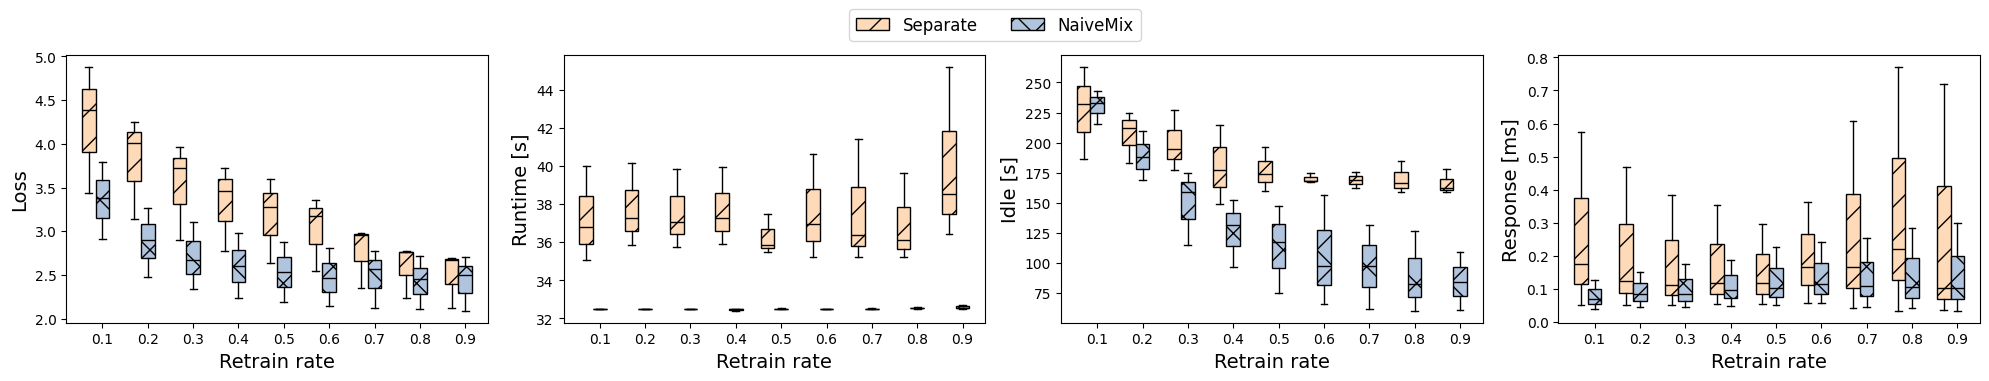

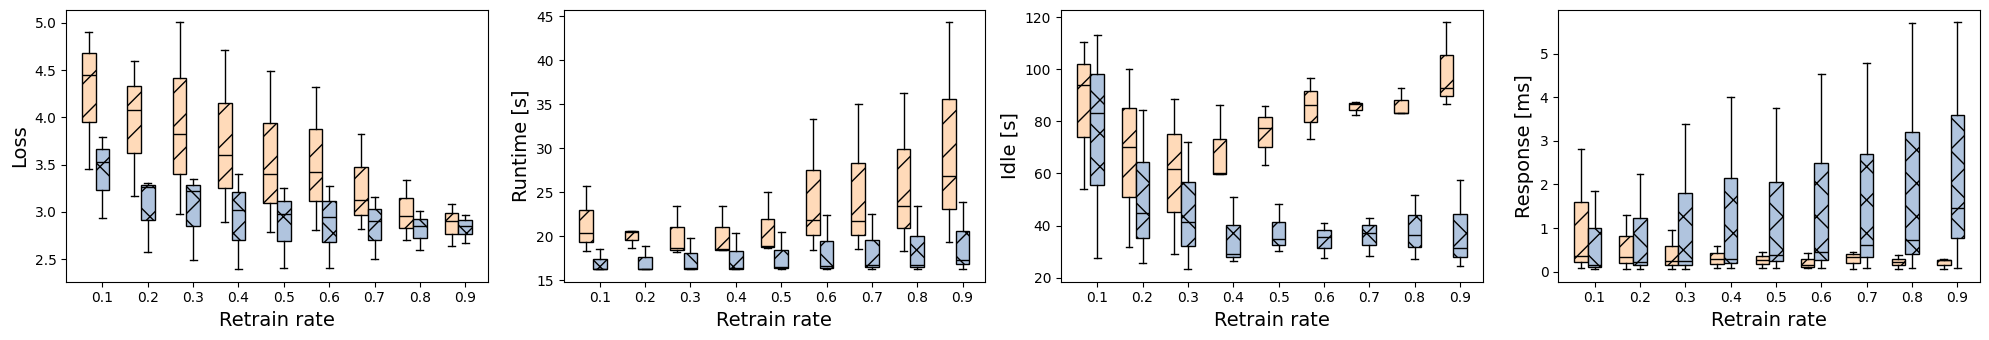

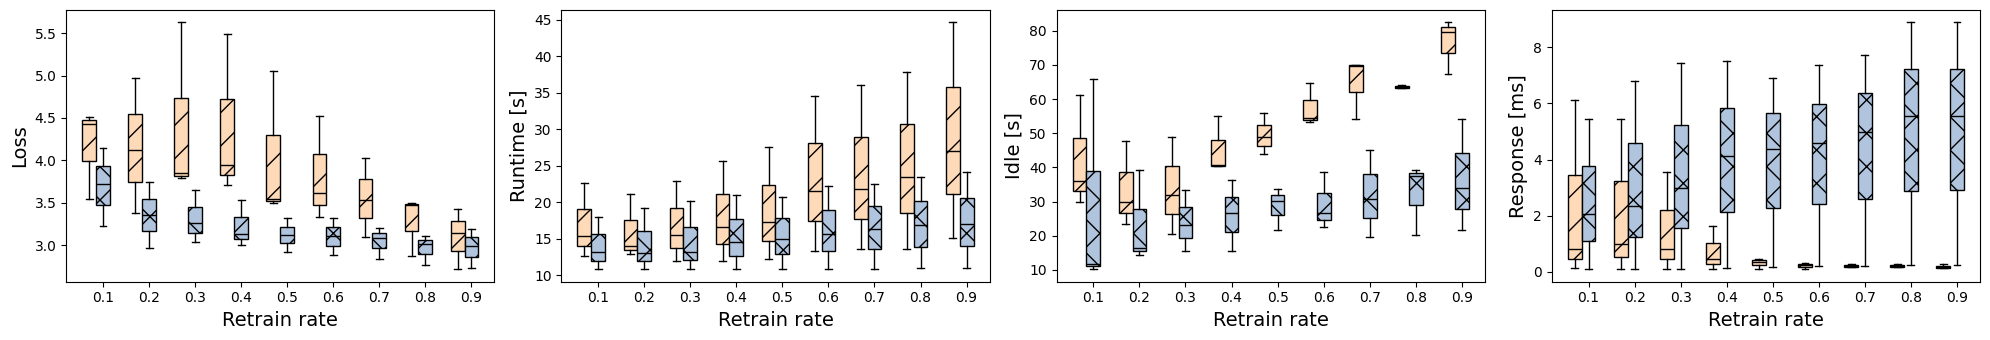

In [14]:
plot_box(num_nodes=2, lambda_=10)
plot_box(num_nodes=2, lambda_=20, legend=False)
plot_box(num_nodes=2, lambda_=30, legend=False)

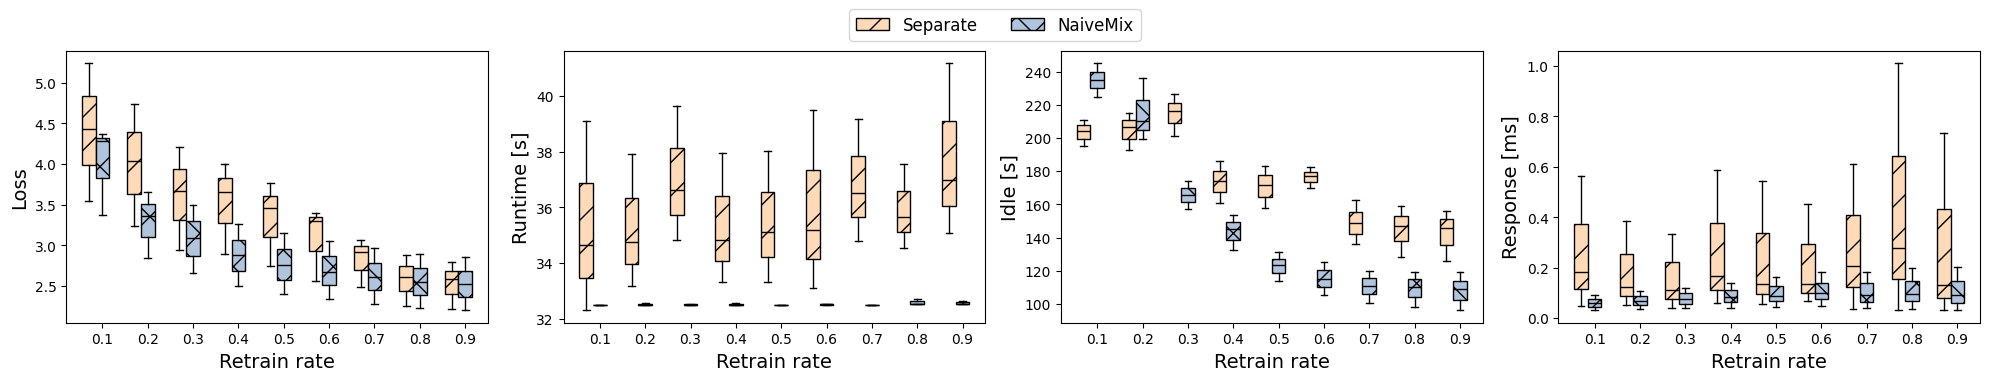

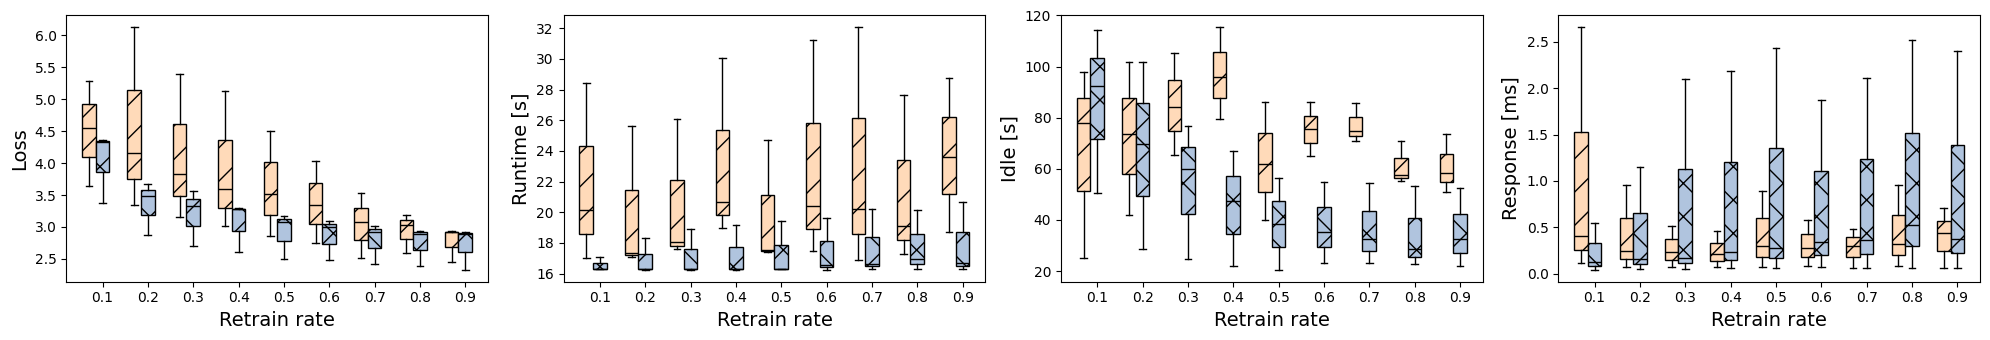

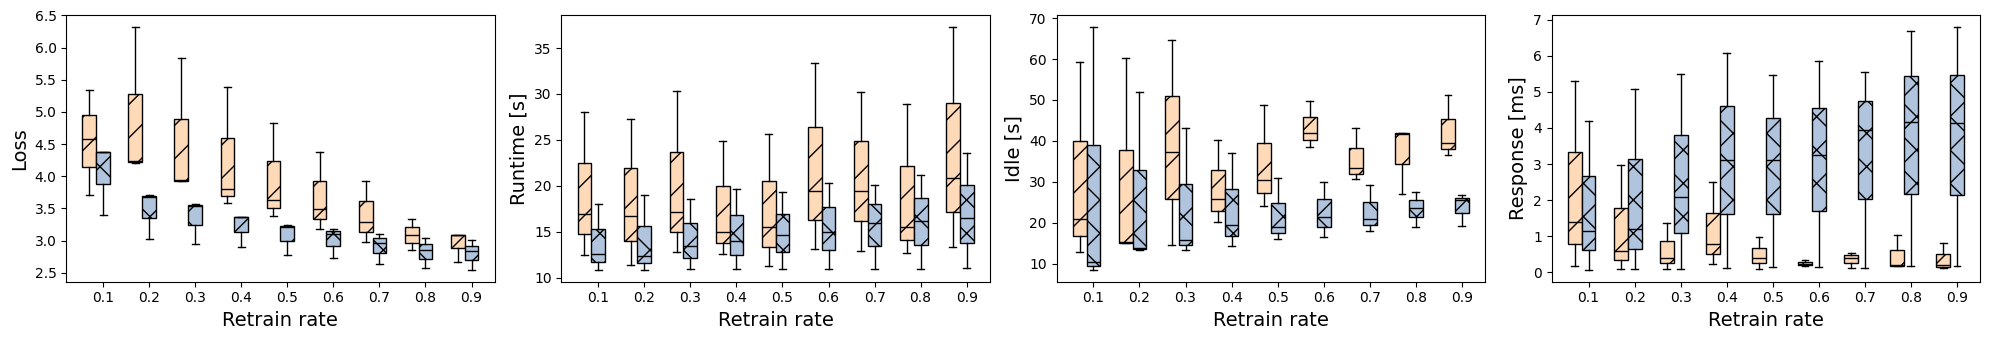

In [15]:
plot_box(num_nodes=4, lambda_=10)
plot_box(num_nodes=4, lambda_=20, legend=False)
plot_box(num_nodes=4, lambda_=30, legend=False)